In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the data from the Excel file
df = pd.read_excel('data.xlsx')

# Convert numeric columns 
df['Order ID'] = pd.to_numeric(df['Order ID'])
df['Order Number'] = pd.to_numeric(df['Order Number'])
df['Vendor to Customer Aerial distance'] = pd.to_numeric(df['Vendor to Customer Aerial distance'])
df['Vendor to Customer Manhattan Distance'] = pd.to_numeric(df['Vendor to Customer Manhattan Distance'])

# Function to convert create time to minutes from midnight
def time_to_min(t):
    if isinstance(t, str):
        try:
            h, m, s = map(int, t.split(':'))
            return h * 60 + m + s / 60.0
        except ValueError:
            # If it's a float in string, convert
            return float(t) * 1440
    elif isinstance(t, float):
        return t * 1440  # fractional day to minutes
    else:
        # If it's a datetime.time object
        return t.hour * 60 + t.minute + t.second / 60.0

df['time_minute'] = df['Create Time'].apply(time_to_min)

# Separate into shifts
df_shift1 = df[df['Time Slot'] == '08-16'].sort_values('time_minute').reset_index(drop=True)
df_shift2 = df[df['Time Slot'] == '16-24'].sort_values('time_minute').reset_index(drop=True)

# Function to create deliveries of 1 or 2 orders
def create_deliveries(df_shift, speed=500, max_orders_per_basket=5, max_delivery_time=42):
    orders = df_shift.to_dict('records')
    deliveries = []
    i = 0

    while i < len(orders):
        basket = [orders[i]]
        i += 1
        
        while i < len(orders) and len(basket) < max_orders_per_basket:
            new_basket = basket + [orders[i]]
            if get_basket_delivery_time(new_basket) <= max_delivery_time:
                basket = new_basket
                i += 1
            else:
                break

        deliveries.append(basket)

    return deliveries
    
        
def get_basket_delivery_time(basket, speed = 500):
    if len(basket) == 1: 
        return basket[0]['Vendor to Customer Manhattan Distance'] / speed; 
    if len(basket) == 2: 
        return (min(order['Vendor to Customer Manhattan Distance'] for order in basket) + sum(order['Vendor to Customer Manhattan Distance'] for order in basket)) / speed 
    avg_distance = sum(order['Vendor to Customer Manhattan Distance'] for order in basket)/ len(basket)
    return 3.14 * 2 * avg_distance / speed


# Function to get busy interval for a delivery
def get_busy_interval(basket):
    # Get the ready time (last order's creation time + 5 minutes preparation)
    start = basket[0]['time_minute'] + 10
    # Sum the Manhattan distances for all orders in the basket
    duration = get_basket_delivery_time(basket)
    # total_distance = sum(order['Vendor to Customer Manhattan Distance'] for order in basket)
    # Calculate total duration: 2 * total_distance / speed (go to customer and return for each order)
    end = start + duration
    return (start, end)


# Function to calculate peak concurrent busy couriers
def calculate_peak(intervals):
    events = []
    for start, end in intervals:
        events.append((start, 1))  # start event
        events.append((end, -1))   # end event
    events.sort()
    current_busy = 0
    max_busy = 0
    for time, delta in events:
        current_busy += delta
        if current_busy > max_busy:
            max_busy = current_busy
    return max_busy

# Process shift 1
deliveries1 = create_deliveries(df_shift1)
intervals1 = [get_busy_interval(d) for d in deliveries1]
peak1 = calculate_peak(intervals1)

# Process shift 2
deliveries2 = create_deliveries(df_shift2)
intervals2 = [get_busy_interval(d) for d in deliveries2]
peak2 = calculate_peak(intervals2)

# Calculate cost
salary_per_courier_per_shift = 400000  # toman
total_couriers_needed = peak1 + peak2
total_orders = len(df)
total_cost = total_couriers_needed * salary_per_courier_per_shift
cost_per_order = total_cost / total_orders if total_orders > 0 else 0

# Output results
print(f"Number of couriers needed for shift 08-16: {peak1}")
print(f"Number of couriers needed for shift 16-24: {peak2}")
print(f"Organization cost per order: {cost_per_order:.2f} toman")

Number of couriers needed for shift 08-16: 18
Number of couriers needed for shift 16-24: 24
Organization cost per order: 22919.51 toman


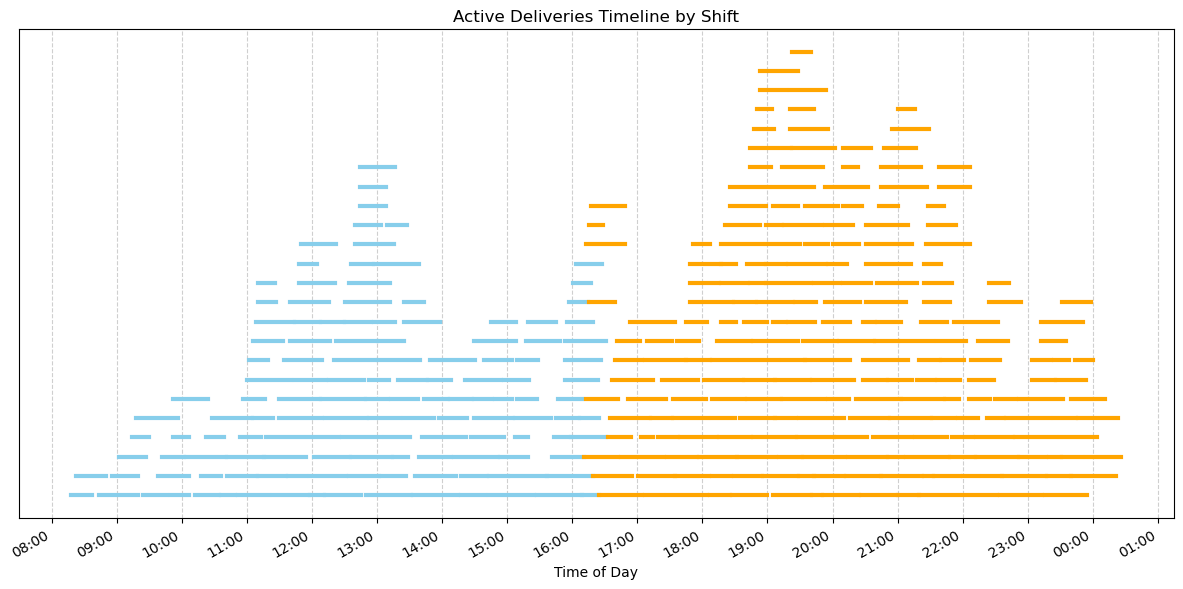

In [224]:


def plot_non_overlapping_timeline(intervals1, intervals2):
    # Tag each interval with its shift
    all_intervals = [(s, e, 1) for s, e in intervals1] + [(s, e, 2) for s, e in intervals2]
    df_plot = pd.DataFrame(all_intervals, columns=["start_min", "end_min", "shift"])

    # Convert to datetime
    base_date = pd.Timestamp("2025-01-01")  # arbitrary date
    df_plot["start_dt"] = base_date + pd.to_timedelta(df_plot["start_min"], unit="m")
    df_plot["end_dt"] = base_date + pd.to_timedelta(df_plot["end_min"], unit="m")

    # Sort by start time
    df_plot = df_plot.sort_values("start_dt").reset_index(drop=True)

    # Assign lanes so bars don't overlap
    lanes = []  # end times of last delivery in each lane
    lane_assignment = []

    for _, row in df_plot.iterrows():
        placed = False
        for lane_index, lane_end_time in enumerate(lanes):
            if row["start_dt"] >= lane_end_time:  # free lane
                lanes[lane_index] = row["end_dt"]
                lane_assignment.append(lane_index)
                placed = True
                break
        if not placed:
            lanes.append(row["end_dt"])
            lane_assignment.append(len(lanes) - 1)

    df_plot["lane"] = lane_assignment

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    for _, row in df_plot.iterrows():
        color = "skyblue" if row["shift"] == 1 else "orange"
        ax.plot([row["start_dt"], row["end_dt"]],
                [row["lane"], row["lane"]],
                color=color, linewidth=3)

    # Format X-axis for whole hours
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Hide Y-axis labels
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.set_xlabel("Time of Day")
    ax.set_title("Active Deliveries Timeline by Shift")
    ax.grid(True, axis="x", linestyle="--", alpha=0.6)
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()

# Call after intervals1 and intervals2
plot_non_overlapping_timeline(intervals1, intervals2)


In [222]:

# --- Generate useful charts and data ---

shifts = ['08-16', '16-24']
couriers_needed = [peak1, peak2]
plt.figure(figsize=(8, 6))
plt.bar(shifts, couriers_needed, color=['skyblue', 'salmon'])
plt.title('Number of Couriers Needed per Shift')
plt.xlabel('Time Shift')
plt.ylabel('Number of Couriers')
plt.savefig('couriers_per_shift_bar_chart.png')
plt.close()

# Bar chart for orders per shift
orders_per_shift = [len(df_shift1), len(df_shift2)]
plt.figure(figsize=(8, 6))
plt.bar(shifts, orders_per_shift, color=['lightgreen', 'orange'])
plt.title('Total Orders per Shift')
plt.xlabel('Time Shift')
plt.ylabel('Number of Orders')
plt.savefig('orders_per_shift_bar_chart.png')
plt.close()

# Calculate cost per order for each shift
cost_per_order_shift1 = (peak1 * salary_per_courier_per_shift) / len(df_shift1) if len(df_shift1) > 0 else 0
cost_per_order_shift2 = (peak2 * salary_per_courier_per_shift) / len(df_shift2) if len(df_shift2) > 0 else 0
cost_per_order_shifts = [cost_per_order_shift1, cost_per_order_shift2]
plt.figure(figsize=(8, 6))
plt.bar(shifts, cost_per_order_shifts, color=['purple', 'teal'])
plt.title('Cost per Order per Shift')
plt.xlabel('Time Shift')
plt.ylabel('Cost per Order (toman)')
plt.savefig('cost_per_order_per_shift_bar_chart.png')
plt.close()

# Histogram of Manhattan Distance
plt.figure(figsize=(8, 6))
plt.hist(df['Vendor to Customer Manhattan Distance'], bins=30, color='lightgray', edgecolor='black')
plt.title('Distribution of Vendor to Customer Manhattan Distance')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.savefig('manhattan_distance_histogram.png')
plt.close()

# Pie chart for delivery types
delivery_type_counts = [single_deliveries_s1 + single_deliveries_s2, multi_deliveries_s1 + multi_deliveries_s2]
delivery_labels = ['Single Order Deliveries', 'Multi-Order Deliveries']
plt.figure(figsize=(8, 6))
plt.pie(delivery_type_counts, labels=delivery_labels, autopct='%1.1f%%', colors=['gold', 'lightcoral'])
plt.title('Distribution of Delivery Types')
plt.savefig('delivery_type_pie_chart.png')
plt.close()

# Create a summary table
summary_data = {
    'Metric': ['Total Orders', 'Total Deliveries', 'Single-Order Deliveries', 'Multi-Order Deliveries', 'Couriers Needed (Shift 08-16)', 'Couriers Needed (Shift 16-24)', 'Total Couriers Needed', 'Total Cost (toman)', 'Overall Cost Per Order (toman)', 'Avg. Aerial Distance', 'Avg. Manhattan Distance', 'Manhattan to Aerial Ratio'],
    'Value': [
        total_orders,
        single_deliveries_s1 + single_deliveries_s2 + multi_deliveries_s1 + multi_deliveries_s2,
        single_deliveries_s1 + single_deliveries_s2,
        multi_deliveries_s1 + multi_deliveries_s2,
        peak1,
        peak2,
        total_couriers_needed,
        total_cost,
        cost_per_order,
        df['Vendor to Customer Aerial distance'].mean(),
        df['Vendor to Customer Manhattan Distance'].mean(),
        df['Vendor to Customer Manhattan Distance'].mean() / df['Vendor to Customer Aerial distance'].mean()
    ]
}
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('summary_report.csv', index=False)


print(summary_data)


{'Metric': ['Total Orders', 'Total Deliveries', 'Single-Order Deliveries', 'Multi-Order Deliveries', 'Couriers Needed (Shift 08-16)', 'Couriers Needed (Shift 16-24)', 'Total Couriers Needed', 'Total Cost (toman)', 'Overall Cost Per Order (toman)', 'Avg. Aerial Distance', 'Avg. Manhattan Distance', 'Manhattan to Aerial Ratio'], 'Value': [733, 347, 34, 313, 18, 24, 42, 16800000, 22919.508867667122, 2382.4515688949523, 4831.93724420191, 2.0281366082262475]}


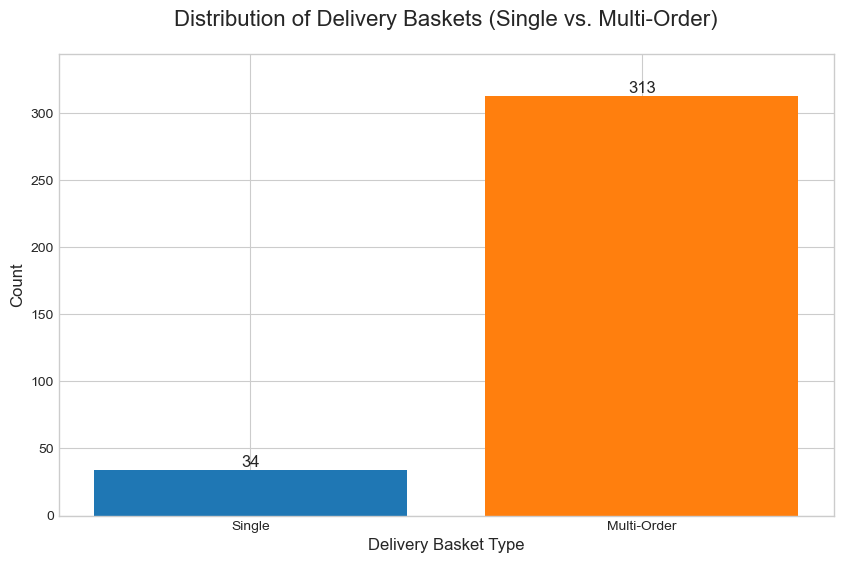

In [226]:

delivery_data = {
    'Order Type': ['Single', 'Multi-Order'],
    'Count': [34, 313]
}
df = pd.DataFrame(delivery_data)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df['Order Type'], df['Count'], color=['#1f77b4', '#ff7f0e'])
ax.set_title('Distribution of Delivery Baskets (Single vs. Multi-Order)', fontsize=16, pad=20)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Delivery Basket Type', fontsize=12)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height}',
            ha='center', va='bottom', fontsize=12)
ax.set_ylim(0, max(df['Count']) * 1.1)
plt.show()
